# Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

file_name = "bpn_parsed_data.parquet"

In [2]:
df = pd.read_parquet(file_name, columns=['url', 'text', 'header'])

In [3]:
df.head()

,url,text,header
0,https://www.bpn.ge/api/article/23772,სამშენებლო კომპანია „საბა კონსტრაქშენმა“ ახალ ...,სამშენებლო კომპანია „საბა კონსტრაქშენმა“ ახალ ...
1,https://www.bpn.ge/api/article/88649,საპენსიო სააგენტოს საინვესტიციო სამსახურის უფრ...,"საპენსიო სააგენტოს წარმომადგენელი - იმ დღიდან,..."
2,https://www.bpn.ge/api/article/15288,ხორვატიის საზღვარი ბოლო 24 საათის განმავლობაში...,ხორვატიის საზღვარი 5 650-მა მიგრანტმა გადაკვეთა
3,https://www.bpn.ge/api/article/2366,2013 წელს ციფრულ რეკლამირებაზე დანახარჯები მსო...,2013 წელს ციფრულ რეკლამირებაზე ხარჯვა გაიზრდება
4,https://www.bpn.ge/api/article/18418,2016 წლის გაზაფხულიდან ჯარი თითქმის სრულად ქარ...,"თინა ხიდაშელი – მაქვს ამბიცია, რომ 2016 წლის გ..."


# Small preprocessing

In [4]:
df['header'] = df['header'].progress_apply(lambda x: x.replace('\xa0', ' '))
df['text'] = df['text'].progress_apply(lambda x: x.replace('\xa0', ' '))

100%|██████████| 131257/131257 [00:00<00:00, 1038284.68it/s]


In [5]:
df.head()

,url,text,header
0,https://www.bpn.ge/api/article/23772,სამშენებლო კომპანია „საბა კონსტრაქშენმა“ ახალ ...,სამშენებლო კომპანია „საბა კონსტრაქშენმა“ ახალ ...
1,https://www.bpn.ge/api/article/88649,საპენსიო სააგენტოს საინვესტიციო სამსახურის უფრ...,"საპენსიო სააგენტოს წარმომადგენელი - იმ დღიდან,..."
2,https://www.bpn.ge/api/article/15288,ხორვატიის საზღვარი ბოლო 24 საათის განმავლობაში...,ხორვატიის საზღვარი 5 650-მა მიგრანტმა გადაკვეთა
3,https://www.bpn.ge/api/article/2366,2013 წელს ციფრულ რეკლამირებაზე დანახარჯები მსო...,2013 წელს ციფრულ რეკლამირებაზე ხარჯვა გაიზრდება
4,https://www.bpn.ge/api/article/18418,2016 წლის გაზაფხულიდან ჯარი თითქმის სრულად ქარ...,"თინა ხიდაშელი – მაქვს ამბიცია, რომ 2016 წლის გ..."


# Counting words and chars

In [6]:
print(len(df))
df = df.drop_duplicates(subset=['text'])
print(len(df))

131257
130616


In [7]:
df['words_count'] = df.progress_apply(lambda x: len(re.sub(r'[^a-zA-Zა-ჰ\s]','',x['header'] + '\n' + x['text']).split()), axis=1)
df['chars_count'] = df.progress_apply(lambda x: len(x['header'] + '\n' + x['text']), axis=1)

print(f"Total number of words are {df['words_count'].sum()}")
print(f"Total number of chars are {df['chars_count'].sum()}")

100%|██████████| 130616/130616 [00:00<00:00, 287739.13it/s]

Total number of words are 26093100
Total number of chars are 254752097


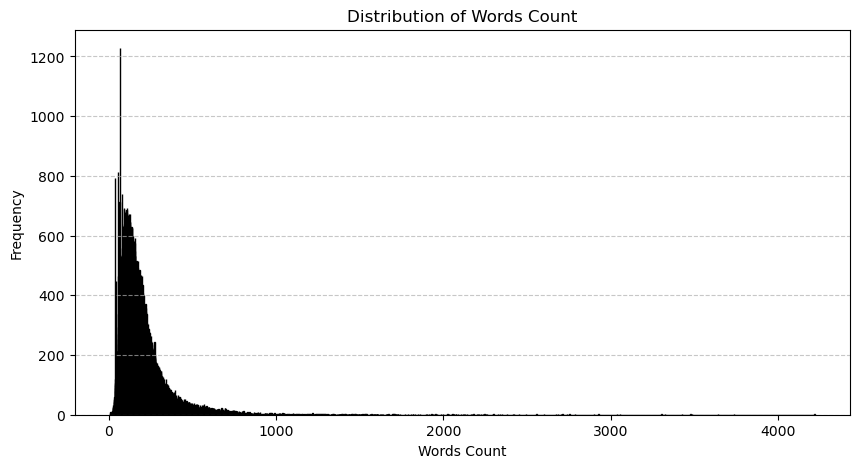

In [8]:
# Plot 1: Distribution of `words_count`
plt.figure(figsize=(10, 5))
plt.hist(df["words_count"], bins=range(df["words_count"].min(), df["words_count"].max() + 2), edgecolor='black', align='left')
plt.title("Distribution of Words Count")
plt.xlabel("Words Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

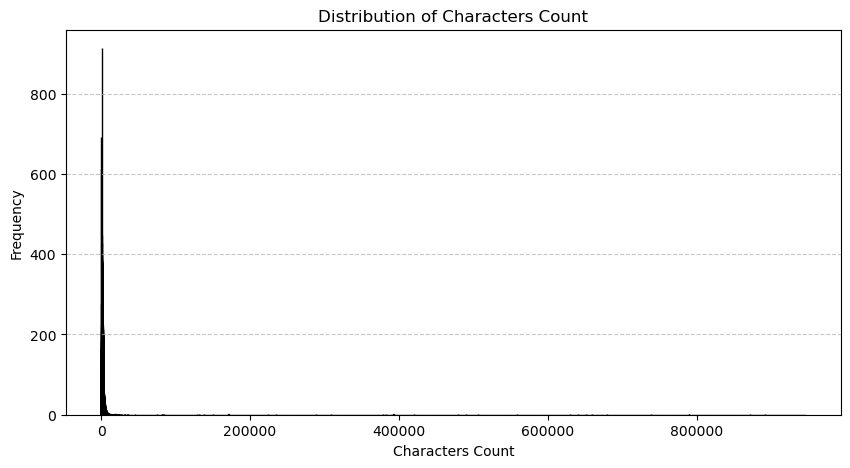

In [9]:
# Plot 2: Distribution of `chars_count`
plt.figure(figsize=(10, 5))
plt.hist(df["chars_count"], bins=range(df["chars_count"].min(), df["chars_count"].max() + 2, 5), edgecolor='black', align='left')
plt.title("Distribution of Characters Count")
plt.xlabel("Characters Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Printing outliers

In [10]:
def find_outliers_df(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter DataFrame for outliers
    outliers_df = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers_df

# Find outliers for `words_count`
words_outliers_df = find_outliers_df(df, "words_count")

# Find outliers for `chars_count`
chars_outliers_df = find_outliers_df(df, "chars_count")

# Combine both to see all outliers in a single DataFrame
extreme_values_df = pd.concat([words_outliers_df, chars_outliers_df]).drop_duplicates()

In [11]:
extreme_values_df.sort_values(by="chars_count", ascending=False).head()

,url,text,header,words_count,chars_count
33589,https://www.bpn.ge/api/article/132684,1940-იანი წლების დასაწყისში ადოლფ ჰიტლერის ბრძ...,როგორ გამოიყურება მე-2 მსოფლიო ომის დროინდელი ...,307,946297
127040,https://www.bpn.ge/api/article/80446,პანდემიისა და გაუფასურებული ლარის გამო დაპაუზე...,",,პანდემიის გამო რამდენიმე თვე პრაქტიკულად, გა...",231,892325
53500,https://www.bpn.ge/api/article/91799,დიზაინერმა ზვიად ციკოლიამ ახალი საათი ORI წარა...,რა ღირს და როგორ გამოიყურება ციკოლიას ახალი სა...,45,871633
122129,https://www.bpn.ge/api/article/103047,ქალაქი დღითი დღე უფრო ხმაურიანი და გაუსაძლისიხ...,HUBMSHENI-ს წარმატების ისტორია,420,789417
117990,https://www.bpn.ge/api/article/113174,"ჩრდილოეთ კორეის ვაჭრობა, ძირითადად მოწყვეტილია...",კიმ ჩენ ინის ვნებანი - რაზე დგას მსოფლიოს ყველ...,795,789313


In [12]:
extreme_values_df.sort_values(by="words_count", ascending=False).head()

,url,text,header,words_count,chars_count
78909,https://www.bpn.ge/api/article/77523,„ქართული ოცნების“ თავმჯდომარე ბიძინა ივანიშვილ...,ბიძინა ივანიშვილი პოლიტიკიდან მიდის - „მივდივა...,4217,36422
4867,https://www.bpn.ge/api/article/104319,"ომი უკრაინაში, რუსეთის წინააღმდეგ დასავლეთის ს...",რა პროექტების განხორციელებას გეგმავს მთავრობა ...,3738,32250
79606,https://www.bpn.ge/api/article/39563,დავით ნარმანია თბილისის მერის თანამდებობაზე 3-...,რა გაკეთდა თბილისში დავით ნარმანიას მერობის დროს,3640,30377
109162,https://www.bpn.ge/api/article/56465,"2014 წელს, რუსეთის ენერგეტიკის სამინისტროს ვებ...",როგორ ებრძვის რუსეთი საქართველოს ენერგოდამოუკი...,3485,34539
62793,https://www.bpn.ge/api/article/59975,მამუკა ბახტაძე პრემიერ-მინისტრის თანამდებობაზე...,მამუკა ბახტაძე მისი პრემიერობისას მთავრობის მი...,3476,32156


In [13]:
extreme_values_df.sort_values(by="chars_count").head()

,url,text,header,words_count,chars_count
29055,https://www.bpn.ge/api/article/89129,"დღეს ამ ტრიბუნასთან, ან უნდა თქვათ, რომ ვერ ას...",ანა ნაცვლიშვილი კობა გვენეტაძეს - ვთქვათ სიმარ...,442,3307
124432,https://www.bpn.ge/api/article/5950,კობა გილაურის მეუღლეს პამიდვრით სავსე ვედროები...,ჭოპორტულას ერთგულებით,451,3333
18439,https://www.bpn.ge/api/article/134788,"მინდა, ყველას მოგილოცოთ 2025 წელი, როგორც ნამდ...","მინდა, ყველას მოგილოცოთ 2025 წელი, როგორც ნამდ...",447,3351
59269,https://www.bpn.ge/api/article/90822,"მე დარწმუნებული ვარ, რომ ჩვენ უახლოეს ხანში ან...","მამუკა ხაზარაძე - მე დარწმუნებული ვარ, რომ ჩვე...",461,3462
52599,https://www.bpn.ge/api/article/82669,"„იმ რეალური მოცემულობით, რა ფასიც იყო პლატცის ...",რა გავლენა მოახდინა ლარის გამყარებამ საწვავის ...,438,3505


In [14]:
extreme_values_df.sort_values(by="words_count").head()

,url,text,header,words_count,chars_count
53500,https://www.bpn.ge/api/article/91799,დიზაინერმა ზვიად ციკოლიამ ახალი საათი ORI წარა...,რა ღირს და როგორ გამოიყურება ციკოლიას ახალი სა...,45,871633
63669,https://www.bpn.ge/api/article/1803,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,68,85071
130675,https://www.bpn.ge/api/article/105318,"NDI-ის კვლევის თანახმად, ყოველი მეხუთე მოქალაქ...",საქართველოს ყოველი მეხუთე მოქალაქე ემიგრაციაში...,86,74593
101601,https://www.bpn.ge/api/article/112503,ჯუთასკენ მივალ გზაზე მეწყრული პროცესების დაწყე...,"""გზა ჰაერშია, ზედა მხარეს კი მეწყრული პროცესია...",97,629492
77754,https://www.bpn.ge/api/article/122147,საქართველო-საბერძნეთის მატჩისთვის ბილეთების შე...,50-ლარიანი ბილეთი 500 ლარად - რა ხდება ბილეთებ...,97,506111


# Words Length Distributions

In [15]:
# Tokenize words and calculate word lengths
all_words = [word for sentence in (df["header"] + ' ' + df['text']) for word in sentence.split()]
word_lengths = [len(word) for word in all_words]

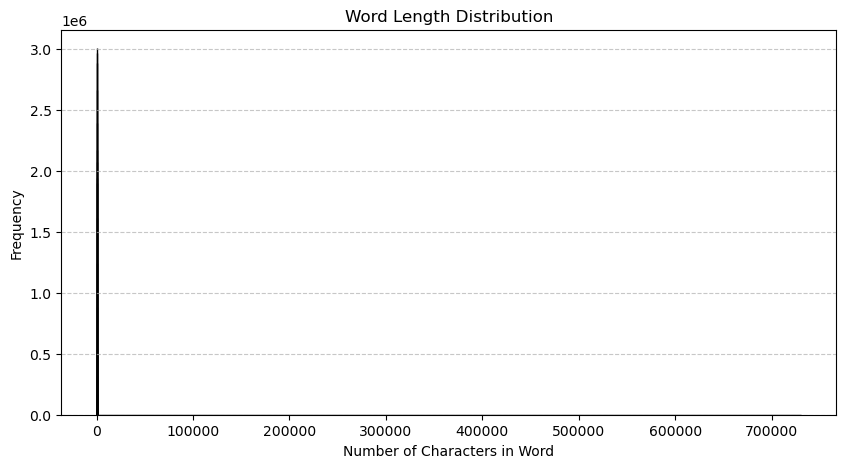

In [16]:
# Plot Word Length Distribution
plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=range(1, max(word_lengths) + 1), edgecolor='black', align='left')
plt.title("Word Length Distribution")
plt.xlabel("Number of Characters in Word")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Combine words with their lengths
word_length_pairs = list(zip(all_words, word_lengths))


# Sort by word length in descending order
sorted_word_length_pairs = sorted(word_length_pairs, key=lambda x: x[1], reverse=True)

# Print top highest words with their lengths
top_n = 10  # Number of top longest words to display
print(f"Top {top_n} longest words with their lengths:")
for word, length in sorted_word_length_pairs[:top_n]:
    print(f"{word}: {length}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Wordclouds

In [27]:
from nltk import ngrams

def ngram_analysis(txt, n=2, top_k=100):
    all_ngrams = [ngram for ngram in ngrams(tqdm(txt.split(), position=0, leave=True), n)]
    ngram_freq = Counter(all_ngrams).most_common(top_k)
    return ngram_freq

In [36]:
# Combine header and text into a single text
text = " ".join(df["header"] + ' ' + df["text"])

# Convert bigram counts to a dictionary
bigram_counts_dict = ngram_analysis(text, 2, top_k=200)

# Convert trigram counts to a dictionary
trigram_counts_dict = ngram_analysis(text, 3, top_k=200)

100%|██████████| 27524372/27524372 [00:05<00:00, 5207209.47it/s]


In [37]:
bigram_wordcloud_dict = {" ".join(k): v for k, v in bigram_counts_dict}
trigram_wordcloud_dict = {" ".join(k): v for k, v in trigram_counts_dict}

In [38]:
del text
import gc

print(f"{gc.collect()} objects collected. {len(gc.get_objects())} total objects in memory.")
print("")

2741 objects collected. 316689 total objects in memory.



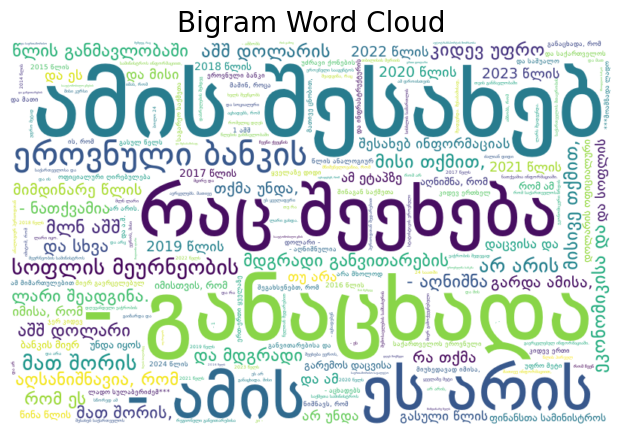

In [39]:
# Generate the word cloud
bigram_wordcloud = WordCloud(
    background_color='white',
    width=800,  # Reduce width
    height=512,  # Reduce height
    font_path='./bpg_dejavu_sans.otf'
).generate_from_frequencies(bigram_wordcloud_dict)


# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram Word Cloud", fontsize=20)
plt.show()

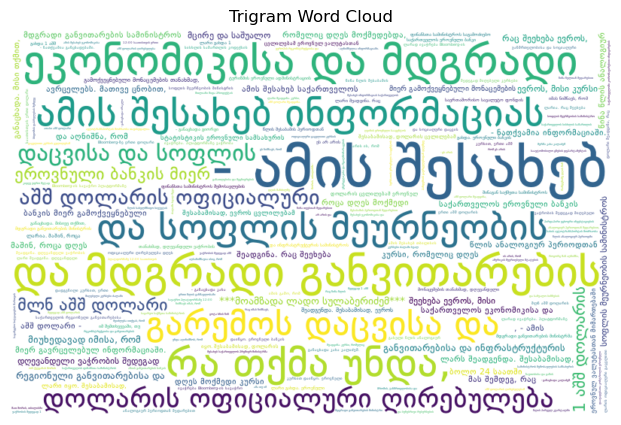

In [40]:
# Generate the word cloud
trigram_wordcloud = WordCloud(
    background_color='white',
    width=800,  # Reduce width
    height=512,  # Reduce height
    font_path='./bpg_dejavu_sans.otf'
).generate_from_frequencies(trigram_wordcloud_dict)

plt.figure(figsize=(10, 5))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Trigram Word Cloud")
plt.show()